In [1]:
import emoji, re, string, time, os
import pandas as pd
import numpy as np
from scipy.stats import randint
import pickle

#nlp
import nltk
from nltk.corpus import stopwords
import spacy

#dataviz
import matplotlib.pyplot as plt
import seaborn as sns

#features
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics.pairwise import linear_kernel
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.decomposition import TruncatedSVD
from sklearn.calibration import CalibratedClassifierCV

#models
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import SGDClassifier
from sklearn.naive_bayes import BernoulliNB
from sklearn.naive_bayes import MultinomialNB
from sklearn.naive_bayes import ComplementNB
from sklearn.ensemble  import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.svm import LinearSVC
from sklearn.neighbors import KNeighborsClassifier

#data balancing
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler

get_ipython().run_line_magic('matplotlib', 'inline')
sns.set(style="darkgrid")

from scipy.sparse import hstack

# cross_validation
from sklearn.model_selection import cross_validate

#Dicionario
import liwc
import re
from collections import Counter


/home/nanda/.pyenv/versions/3.10.2/lib/python3.10/site-packages/torch/cuda/__init__.py:141: UserWarning: CUDA initialization: CUDA unknown error - this may be due to an incorrectly set up environment, e.g. changing env variable CUDA_VISIBLE_DEVICES after program start. Setting the available devices to be zero. (Triggered internally at ../c10/cuda/CUDAFunctions.cpp:108.)
  return torch._C._cuda_getDeviceCount() > 0


In [2]:
filepath = 'Correto_whatsapp_rotulado_revisado.csv'
df = pd.read_csv(filepath)    

1. Visão Geral do Dataset:
- Número de Linhas: 3000
- Número de Colunas: 2

- Primeiros 5 registros:
                              text_content_anonymous  preconceito
0  Show :clapping_hands_light_skin_tone::clapping...            0
1  Mais uma vez o PT= Partido das Trevas apela ao...            1
2  Se não puder avise só para não quebrar a vigíl...            0
3              E a esquerda tenta impedir o trabalho            0
4  Deus perdoa porque eles Não sabem que fazem e ...            0

2. Informações Básicas:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3000 entries, 0 to 2999
Data columns (total 2 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   text_content_anonymous  2999 non-null   object
 1   preconceito             3000 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 47.0+ KB
None

3. Estatísticas Descritivas:
                                   text_content_anonymous  preconceito
count  

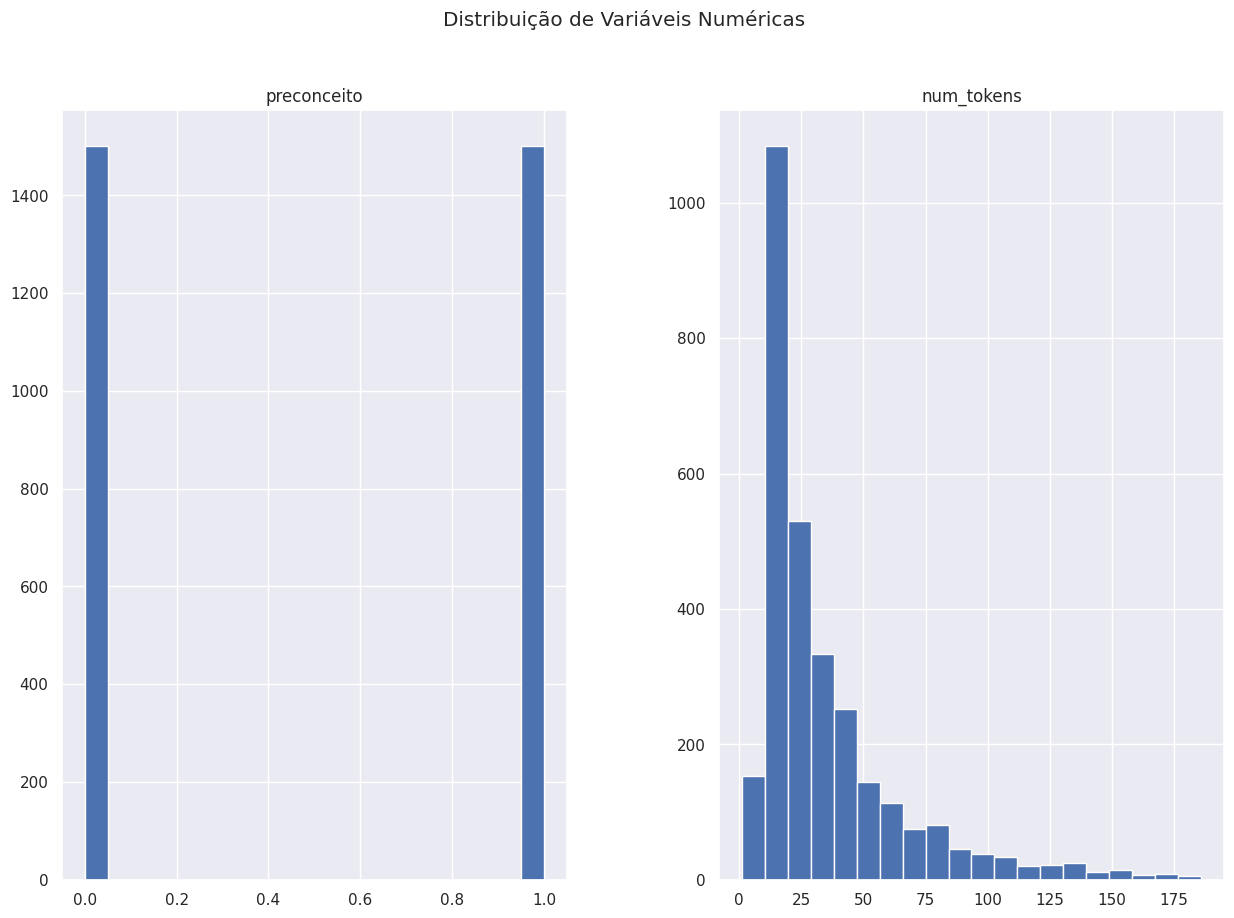


6. Distribuição de Variáveis Categóricas:

Coluna: text_content_anonymous
text_content_anonymous
Show :clapping_hands_light_skin_tone::clapping_hands_light_skin_tone::clapping_hands_light_skin_tone::clapping_hands_light_skin_tone::clapping_hands_light_skin_tone:   O Nordestino acordou                                                                                                                                                                                                    1
PESSOAL,  BÓRA DIVULGAR ESSE RETARDADO FAZENDO CAMPANHA PRA RISCAR CARROS COM ADESIVOS BOLSONARO!\nVAMOS ACABAR COM A CARREIRA DELE!                                                                                                                                                                                                                                                            1
Fui ameaçada de morte :woman_facepalming_medium-light_skin_tone:\nMandei até a localização pra vadia                              

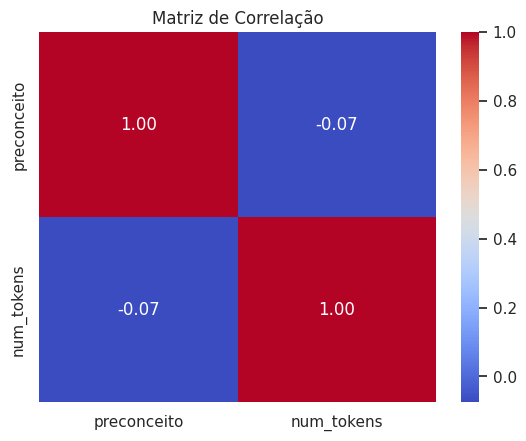


8. Outliers (Boxplots para Variáveis Numéricas):


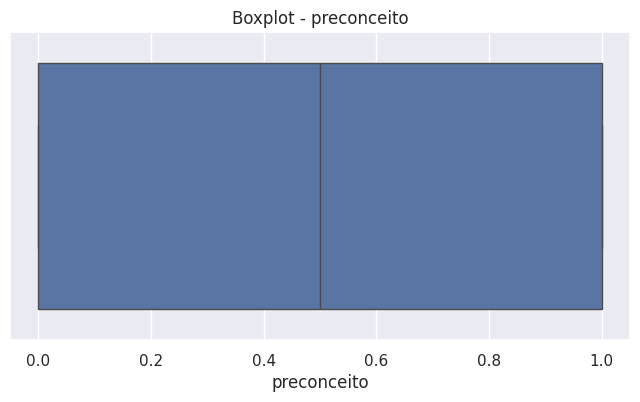

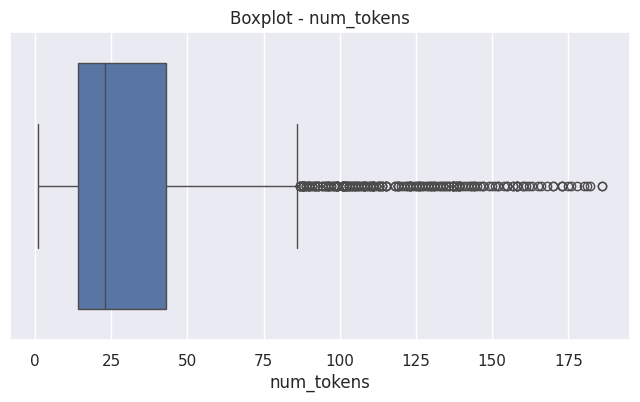


10. Dados Duplicados:
- Total de Registros Duplicados: 0


In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns


# 1. Visão Geral do Dataset
print("1. Visão Geral do Dataset:")
print(f"- Número de Linhas: {df.shape[0]}")
print(f"- Número de Colunas: {df.shape[1]}")
print("\n- Primeiros 5 registros:")
print(df.head())

# 2. Informações Básicas
print("\n2. Informações Básicas:")
print(df.info())

# 3. Estatísticas Descritivas
print("\n3. Estatísticas Descritivas:")
print(df.describe(include='all'))  # Inclui colunas categóricas e numéricas

mensagens_coluna = 'text_content_anonymous'  # Altere para o nome correto da coluna com as mensagens
df[mensagens_coluna] = df[mensagens_coluna].astype(str)

# Tokenizar mensagens (simples divisão por espaços)
df['num_tokens'] = df[mensagens_coluna].apply(lambda x: len(x.split()))

# 1. Quantidade de mensagens únicas
mensagens_unicas = df[mensagens_coluna].nunique()

# 2. Média e desvio-padrão do número de tokens
media_tokens = df['num_tokens'].mean()
desvio_tokens = df['num_tokens'].std()

print(media_tokens)
print(desvio_tokens)

# 3. Número mínimo de tokens
min_tokens = df['num_tokens'].min()

print(min_tokens)

# 4. Número máximo de tokens
max_tokens = df['num_tokens'].max()
print(max_tokens)

# 4. Checagem de Valores Nulos
print("\n4. Valores Nulos:")
print(df.isnull().sum())

# 5. Distribuição de Variáveis Numéricas
print("\n5. Distribuição de Variáveis Numéricas:")
numeric_cols = df.select_dtypes(include=['float64', 'int64']).columns
df[numeric_cols].hist(bins=20, figsize=(15, 10))
plt.suptitle("Distribuição de Variáveis Numéricas")
plt.show()

# 6. Distribuição de Variáveis Categóricas
print("\n6. Distribuição de Variáveis Categóricas:")
categorical_cols = df.select_dtypes(include=['object', 'category']).columns
for col in categorical_cols:
    print(f"\nColuna: {col}")
    print(df[col].value_counts())

# 7. Matriz de Correlação
if not numeric_cols.empty:
    print("\n7. Matriz de Correlação:")
    corr_matrix = df[numeric_cols].corr()
    sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap="coolwarm")
    plt.title("Matriz de Correlação")
    plt.show()

# 8. Outliers (Boxplots para Numéricos)
print("\n8. Outliers (Boxplots para Variáveis Numéricas):")
for col in numeric_cols:
    plt.figure(figsize=(8, 4))
    sns.boxplot(x=df[col])
    plt.title(f"Boxplot - {col}")
    plt.show()

# 9. Distribuição de Classes (se houver uma variável target)
if 'target' in df.columns:
    print("\n9. Distribuição de Classes (Target):")
    print(df['target'].value_counts(normalize=True))
    df['target'].value_counts().plot(kind='bar', title="Distribuição da Variável Target")
    plt.show()

# 10. Checagem de Dados Duplicados
print("\n10. Dados Duplicados:")
duplicates = df.duplicated().sum()
print(f"- Total de Registros Duplicados: {duplicates}")


# Funções que serão usadas para processamento de texto

In [4]:
unicode_emoji = {}
for key, value in emoji.EMOJI_DATA.items():
    try:
        unicode_emoji[key] = value['pt']
    except:
        pass

#emojis and punctuation
emojis_list = list(unicode_emoji)
punct = list(string.punctuation)
emojis_punct = emojis_list + punct

def processEmojisPunctuation(text, remove_punct = True):
    '''
    Put spaces between emojis. Removes punctuation.
    '''
    #get all unique chars
    chars = set(text)
    #for each unique char in text, do:
    for c in chars:
        #remove punctuation
        if remove_punct:
            if c in emojis_list:
                text = text.replace(c, ' ' + c + ' ')
            if c in punct:
                text = text.replace(c, ' ')

        #put spaces between punctuation
        else:
            if c in emojis_punct:
                text = text.replace(c, ' ' + c + ' ')          

    text = text.replace('  ', ' ')
    return text

#stop words removal
stop_words = list(stopwords.words('portuguese'))
new_stopwords = ['aí','pra','vão','vou','onde','lá','aqui',
                 'tá','pode','pois','so','deu','agora','todo',
                 'nao','ja','vc', 'bom', 'ai','kkk','kkkk','ta', 'voce', 'alguem', 'ne', 'pq',
                 'cara','to','mim','la','vcs','tbm', 'tudo']
stop_words = stop_words + new_stopwords
final_stop_words = []
for sw in stop_words:
    sw = ' '+ sw + ' '
    final_stop_words.append(sw)

def removeStopwords(text):
    for sw in final_stop_words:
        text = text.replace(sw,' ')
    text = text.replace('  ',' ')
    return text

#lemmatization
nlp = spacy.load('pt_core_news_sm')
def lemmatization(text):
    doc = nlp(text)
    for token in doc:
        if token.text != token.lemma_:
            text = text.replace(token.text, token.lemma_)
    return text


def domainUrl(text):
    '''
    Substitutes an URL in a text for the domain of this URL
    Input: an string
    Output: the string with the modified URL
    '''    
    if 'http' in text:
        re_url = '[^\s]*https*://[^\s]*'
        matches = re.findall(re_url, text, flags=re.IGNORECASE)
        for m in matches:
            domain = m.split('//')
            domain = domain[1].split('/')[0]
            text = re.sub(re_url, domain, text, 1)
        return text
    else:
        return text 

def preprocess(text):
    text = text.lower().strip()
    text = domainUrl(text)
    text = processEmojisPunctuation(text)
    text = removeStopwords(text)
    text = lemmatization(text)
    return text


# Funções para carregar o dicionário e contar categorias

In [5]:
def read_dic(filepath):
    """
    Reads a LIWC lexicon from a file in the .dic format, returning a tuple of
    (lexicon, category_names), where:
    * `lexicon` is a dict mapping string patterns to lists of category names
    * `category_names` is a list of category names (as strings)
    """
    with open(filepath, 'r', encoding='ISO-8859-1') as lines:
        # read up to first "%" (should be very first line of file)
        for line in lines:
            if line.strip() == "%":
                break
        category_names = []
        for line in lines:
            category_names.append(line.strip().split()[1])

    lexicon = {}
    for line in lines:
        pattern, *categories = line.strip().split()
        lexicon[pattern] = categories

    return lexicon, category_names


In [6]:
def carregar_dicionario_personalizado(dic_path):
    categorias = {}
    lexicon = {}
    dentro_das_categorias = False
    
    with open(dic_path, 'r', encoding='utf-8') as file:
        for linha in file:
            linha = linha.strip()
            
            # Detecta a seção de categorias delimitada por '%'
            if linha == '%':
                dentro_das_categorias = not dentro_das_categorias
                continue
            
            # Lê as categorias personalizadas
            if dentro_das_categorias:
                codigo, categoria = linha.split()
                categorias[codigo] = categoria
            else:
                # Lê as palavras e suas categorias
                partes = linha.split("\t")
                palavra = partes[0]
                categoria_ids = partes[1:]
                lexicon[palavra] = [categorias[codigo] for codigo in categoria_ids if codigo in categorias]
    
    return lexicon, list(categorias.values())

# Caminho do arquivo .dic personalizado
dic_path = 'v2_SocialLIWC_formatado_ordenado.dic'
lexicon, category_names = carregar_dicionario_personalizado(dic_path)

In [7]:
# Passo 3: Função de tokenização
def tokenize(text):
    tokens = []
    for match in re.finditer(r"\w+", text, re.UNICODE):
        tokens.append(match.group(0).lower())
    return tokens

In [8]:
df = df.reindex(columns=df.columns.tolist() + category_names)
df[category_names] = 0 

In [9]:
def verificar_categorias(frase, lexicon):
    tokens = tokenize(frase)
    resultados = {categoria: 0 for categoria in category_names}
    
    for token in tokens:
        if token in lexicon:
            for categoria in lexicon[token]:
                resultados[categoria] = 1
    
    return resultados

In [10]:
lexicon, category_names = carregar_dicionario_personalizado(dic_path)
print("Lexicon carregado:", lexicon)
print("Categorias:", category_names)


Lexicon carregado: {'aberração': ['Capacitismo'], 'aberração*': ['Capacitismo'], 'aberrações': ['Capacitismo'], 'aleij*': ['Capacitismo'], 'aleija': ['Capacitismo'], 'aleijada': ['Capacitismo'], 'aleijadas': ['Capacitismo'], 'aleijadinha': ['Capacitismo'], 'aleijadinho': ['Capacitismo'], 'aleijado': ['Capacitismo'], 'aleijados': ['Capacitismo'], 'aleijai': ['Capacitismo'], 'analfabeto': ['Capacitismo', 'Xenofobia'], 'anormais': ['Capacitismo'], 'anormal': ['Capacitismo'], 'atrasada': ['Capacitismo', 'Xenofobia'], 'atrasadas': ['Capacitismo', 'Xenofobia'], 'atrasado': ['Capacitismo', 'Xenofobia'], 'atrasados': ['Capacitismo', 'Xenofobia'], 'autista': ['Capacitismo'], 'bobo': ['Capacitismo'], 'burro': ['Capacitismo'], 'burros': ['Capacitismo'], 'capenga': ['Capacitismo'], 'ceg*': ['Capacitismo'], 'cego': ['Capacitismo'], 'cegos': ['Capacitismo'], 'cegou': ['Capacitismo'], 'ceguei': ['Capacitismo'], 'cegueir*': ['Capacitismo'], 'cegueta': ['Capacitismo'], 'ceguinha': ['Capacitismo'], 'ceg

In [11]:
# Passo 6: Aplica a verificação de categorias em cada frase do dataframe
for i, frase in df["text_content_anonymous"].items():
    resultados = verificar_categorias(frase, lexicon)
    for categoria, valor in resultados.items():
        df.at[i, categoria] = valor

# Exibe o DataFrame atualizado
df.head(25)

,text_content_anonymous,preconceito,num_tokens,Capacitismo,Gordofobia,Int.Religiosa,LGBTFobia,Misoginia,Xenofobia,Racismo,Hetarismo,Prec.Politico
0,Show :clapping_hands_light_skin_tone::clapping...,0,5,0,0,0,0,0,1,0,0,0
1,Mais uma vez o PT= Partido das Trevas apela ao...,1,43,0,0,0,0,0,0,0,0,0
2,Se não puder avise só para não quebrar a vigíl...,0,123,0,0,1,0,0,0,0,0,1
3,E a esquerda tenta impedir o trabalho,0,7,0,0,0,0,0,0,0,0,0
4,Deus perdoa porque eles Não sabem que fazem e ...,0,15,0,0,1,0,0,0,0,0,1
5,Abre o esgoto que vc chama de boca porra e adm...,1,17,0,0,1,0,1,0,0,0,1
6,A ditadura lulocomunista está na nossa porta. ...,1,53,0,0,0,0,0,0,0,0,1
7,:backhand_index_pointing_up: *Católicos do Bra...,1,29,0,0,0,0,0,0,0,0,0
8,Calma aí\nBasta reverter 3 milhões de votos\nT...,0,55,0,0,0,0,0,0,0,0,0
9,A gente pode manda em Deus ??? Ser ele tem um ...,0,27,1,0,1,0,0,0,0,0,1


In [12]:
# Salva o resultado em um novo CSV
df.to_csv("resultado_categorias_personalizado.csv", index=False)

Capacitismo       457
Gordofobia         43
Int.Religiosa    1002
LGBTFobia         118
Misoginia         251
Xenofobia         230
Racismo           260
Hetarismo          60
Prec.Politico    1536
dtype: int64


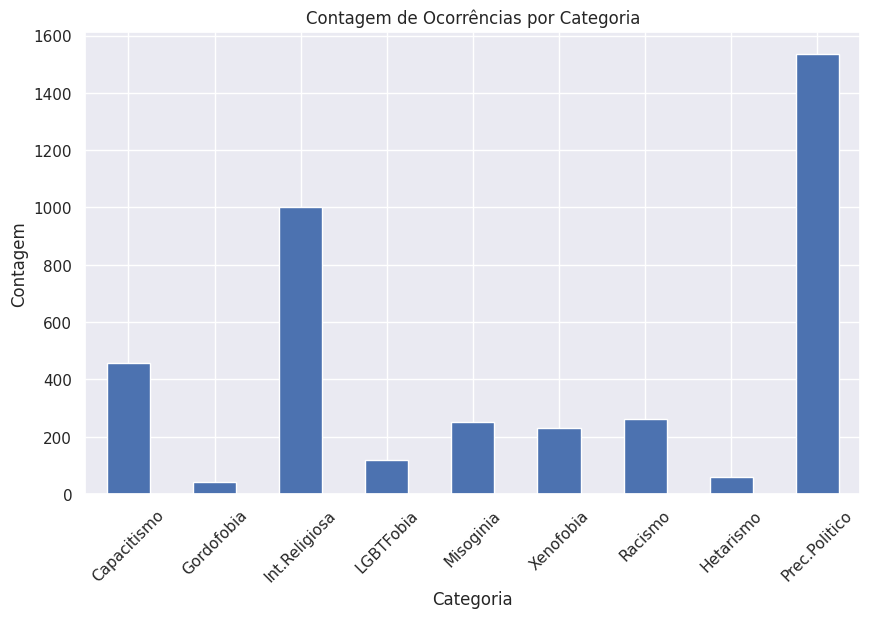

In [13]:
# Passo 7: Contagem de ocorrências de cada categoria
contagem_categorias = df[category_names].sum()

print(contagem_categorias)

# Passo 8: Plotagem do gráfico
plt.figure(figsize=(10, 6))
contagem_categorias.plot(kind='bar')
plt.title("Contagem de Ocorrências por Categoria")
plt.xlabel("Categoria")
plt.ylabel("Contagem")
plt.xticks(rotation=45)
plt.show()

In [14]:
# Definir experimentos: com e sem processamento
experiments = [
    'ml-dic',
    'ml-dic-processed'
]

In [15]:
# Selecionar as colunas das categorias e o rótulo
category_columns = [
    'Capacitismo', 'Gordofobia', 'Int.Religiosa', 'LGBTFobia',
    'Misoginia', 'Xenofobia', 'Racismo', 'Hetarismo', 'Prec.Politico'
]

# Função de pré-processamento
def preprocess_data(df, experiment):
    if experiment == 'processed':
        print("Pré-processamento ativado.")
        pro_texts = [preprocess(t) for t in df['text_content_anonymous']]
    else:
        print("Sem pré-processamento.")
        pro_texts = [processEmojisPunctuation(t.lower(), remove_punct=False) for t in df['text_content_anonymous']]
    return pro_texts

# Rodar para cada experimento
for experiment in experiments:
    start_time = time.time()

    try:
        print(f"Rodando experimento: {experiment}")

        # Removendo duplicatas e lidando com valores ausentes
        df = df.drop_duplicates(subset=['text_content_anonymous'])
        df['text_content_anonymous'] = df['text_content_anonymous'].fillna("")
        df['text_content_anonymous'] = df['text_content_anonymous'].astype(str)

        # Processar textos dependendo do experimento
        pro_texts = preprocess_data(df, experiment)

        # Usar categorias como dados de entrada
        X = df[category_columns]
        y = df['preconceito']
        vocab_size = X.shape[1]  # Número de atributos (categorias)

        # Dividir os dados em treino e teste
        X_train, X_test, y_train, y_test = train_test_split(
            X, y, test_size=0.2, stratify=y, random_state=42
        )

        # Definir os modelos a serem usados
        models = [
            LogisticRegression(), BernoulliNB(), MultinomialNB(), LinearSVC(dual=False),
            KNeighborsClassifier(), SGDClassifier(), RandomForestClassifier(),
            GradientBoostingClassifier(n_estimators=200),
            MLPClassifier(batch_size=64, max_iter=50, early_stopping=True, verbose=False)
        ]

        resultados = []

        # Avaliando os modelos
        for model in models:
            resultado_linha = dict()
            resultado_linha['model'] = model.__class__.__name__
            resultado_linha['vocab_size'] = vocab_size  # Adicionando o tamanho do vocabulário

            # Medir o tempo de execução
            model_start_time = time.time()
            metodos_scoring = ['accuracy', 'precision', 'recall', 'f1', 'roc_auc']
            cv_results = cross_validate(model, X_train, y_train, cv=5, scoring=metodos_scoring, return_train_score=True)
            model_end_time = time.time()
            execution_time = model_end_time - model_start_time

            resultado_linha['execution_time'] = execution_time

            # Salvar as métricas
            for scoring in metodos_scoring:
                scores = cv_results[f'test_{scoring}']
                resultado_linha[f'{scoring}_avg'] = scores.mean()
                resultado_linha[f'{scoring}_std'] = scores.std()

            resultados.append(resultado_linha)

            # Printar informações durante a execução
            print(f"Model: {model.__class__.__name__} | Experiment: {experiment}")
            print(f"Vocab Size (Atributos): {vocab_size}")
            print(f"Execution Time: {execution_time:.2f} seconds")
            print("-" * 50)

        # Tempo total do experimento
        experiment_time = time.time() - start_time
        print(f"Tempo total do experimento '{experiment}': {experiment_time:.2f} seconds")

        # Criar um DataFrame com os resultados
        df_metrics = pd.DataFrame(resultados)
        df_metrics['total_time'] = experiment_time  # Adicionando o tempo total

        # Salvar os resultados em um arquivo CSV
        path_to_save = f"resultados_{experiment}.csv"
        df_metrics.to_csv(path_to_save, index=False)

        print(f"Resultados salvos em: {path_to_save}")

    except Exception as e:
        print(f"[{experiment}] Erro ao executar o experimento: {e}")

Rodando experimento: ml-dic
Sem pré-processamento.
Model: LogisticRegression | Experiment: ml-dic
Vocab Size (Atributos): 9
Execution Time: 0.29 seconds
--------------------------------------------------
Model: BernoulliNB | Experiment: ml-dic
Vocab Size (Atributos): 9
Execution Time: 0.19 seconds
--------------------------------------------------
Model: MultinomialNB | Experiment: ml-dic
Vocab Size (Atributos): 9
Execution Time: 0.12 seconds
--------------------------------------------------
Model: LinearSVC | Experiment: ml-dic
Vocab Size (Atributos): 9
Execution Time: 0.26 seconds
--------------------------------------------------
Model: KNeighborsClassifier | Experiment: ml-dic
Vocab Size (Atributos): 9
Execution Time: 1.02 seconds
--------------------------------------------------
Model: SGDClassifier | Experiment: ml-dic
Vocab Size (Atributos): 9
Execution Time: 0.32 seconds
--------------------------------------------------
Model: RandomForestClassifier | Experiment: ml-dic
Voca